<a href="https://colab.research.google.com/github/Derun-Chai/Assignment3/blob/https%2Fgithub.com%2FAlocinYerv%2FTulip.git/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Raoul Malm  

**Description:**

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented.

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>

In [72]:
pip install --upgrade tensorflow


In [73]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.enable_eager_execution()


# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));


2.15.0
/: ['mnt', 'dev', 'libx32', 'proc', 'usr', 'lib32', 'srv', 'sys', 'boot', 'tmp', 'lib64', 'sbin', 'run', 'home', 'opt', 'lib', 'media', 'etc', 'var', 'root', 'bin', 'content', '.dockerenv', 'tools', 'datalab', 'python-apt', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']
/content: ['.config', 'prices-split-adjusted.csv', 'sample_data']


# 2. Analyze data <a class="anchor" id="2-bullet"></a>
- load stock prices from prices-split-adjusted.csv
- analyze data

In [74]:
# import all stock prices
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['CTXS', 'CHK', 'FAST', 'PVH', 'TXN', 'PSX', 'DVA', 'EXR', 'MAC', 'ARNC']


In [75]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [76]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


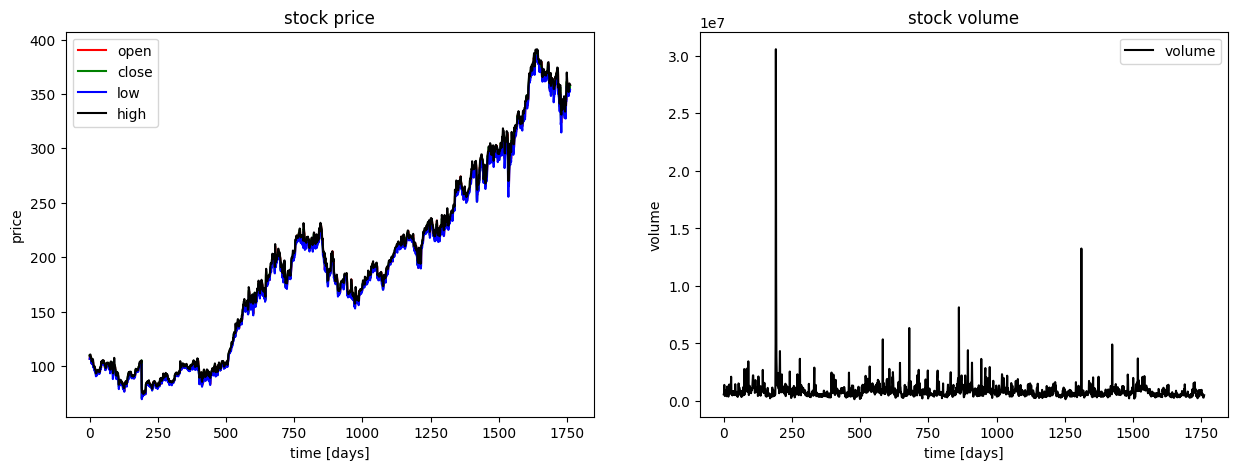

In [78]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# 3. Manipulate data <a class="anchor" id="3-bullet"></a>
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [79]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


<ipython-input-79-98d95818bdb6>:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['symbol'],1,inplace=True)
<ipython-input-79-98d95818bdb6>:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_stock.drop(['volume'],1,inplace=True)


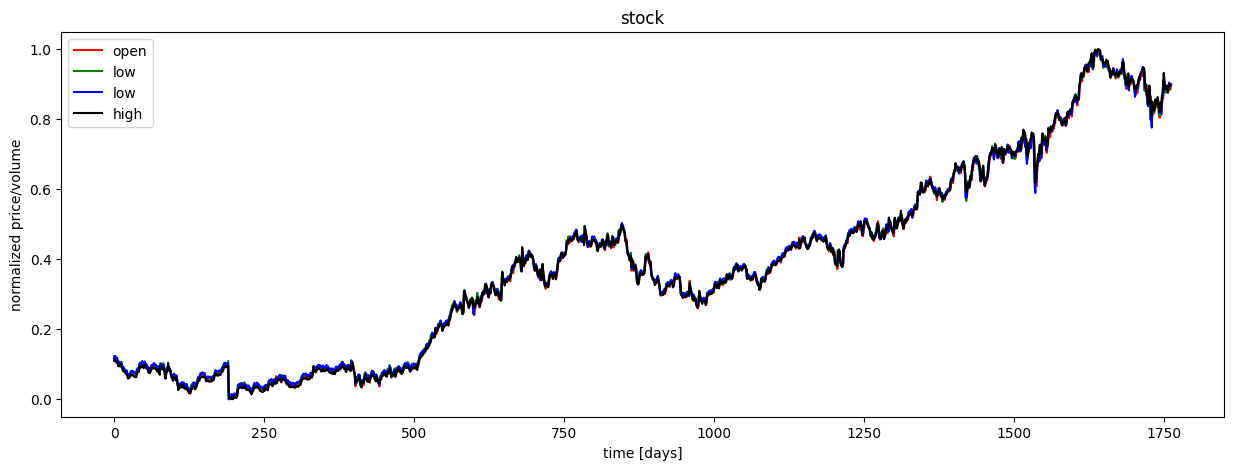

In [80]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a>
- RNNs with basic, LSTM, GRU cells


Adjusted Shapes:
x_train_adjusted: (1390, 19, 4), y_train_residual: (1390, 4)
x_valid_adjusted: (170, 19, 4), y_valid_residual: (170, 4)
x_test_adjusted: (170, 19, 4), y_test_residual: (170, 4)
Epoch 1/60
11/11 [==============================] - 3s 138ms/step - loss: 2.3781 - val_loss: 0.1838
Epoch 2/60
11/11 [==============================] - 2s 156ms/step - loss: 0.0411 - val_loss: 0.2776
Epoch 3/60
11/11 [==============================] - 2s 154ms/step - loss: 0.0695 - val_loss: 0.0610
Epoch 4/60
11/11 [==============================] - 2s 161ms/step - loss: 0.1100 - val_loss: 0.3741
Epoch 5/60
11/11 [==============================] - 2s 168ms/step - loss: 0.0990 - val_loss: 0.4394
Epoch 6/60
11/11 [==============================] - 1s 107ms/step - loss: 0.1011 - val_loss: 0.2023
Epoch 7/60
11/11 [==============================] - 1s 96ms/step - loss: 0.1167 - val_loss: 0.4701
Epoch 8/60
11/11 [==============================] - 1s 90ms/step - loss: 0.1009 - val_loss: 0.0468
Epoch 9/

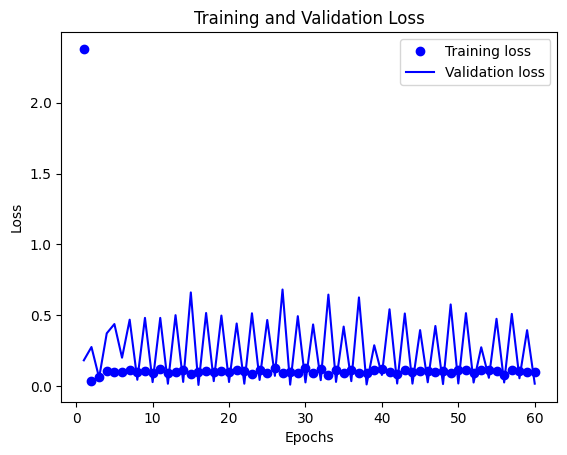

In [81]:
## Basic Cell RNN in tensorflow

# Function to calculate moving average
def calculate_moving_average(data, window_size=5):
    ma = np.zeros((data.shape[0] - window_size + 1, data.shape[1]))
    for i in range(data.shape[1]):
        ma[:, i] = np.convolve(data[:, i], np.ones(window_size) / window_size, mode='valid')
    return ma

# Calculate moving averages for y_train, y_valid, y_test
window_size = 5
y_train_ma = calculate_moving_average(y_train, window_size)
y_valid_ma = calculate_moving_average(y_valid, window_size)
y_test_ma = calculate_moving_average(y_test, window_size)

# Adjust y_train, y_valid, and y_test to match the length of the moving averages
y_train_adjusted = y_train[window_size-1:]
y_valid_adjusted = y_valid[window_size-1:]
y_test_adjusted = y_test[window_size-1:]

# Calculate residuals
y_train_residual = y_train_adjusted - y_train_ma
y_valid_residual = y_valid_adjusted - y_valid_ma
y_test_residual = y_test_adjusted - y_test_ma


# Adjust x_train, x_valid, and x_test to align with the new length of your target variables
x_train_adjusted = x_train[-y_train_residual.shape[0]:, :, :]
x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:, :, :]
x_test_adjusted = x_test[-y_test_residual.shape[0]:, :, :]
print("Adjusted Shapes:")
print(f"x_train_adjusted: {x_train_adjusted.shape}, y_train_residual: {y_train_residual.shape}")
print(f"x_valid_adjusted: {x_valid_adjusted.shape}, y_valid_residual: {y_valid_residual.shape}")
print(f"x_test_adjusted: {x_test_adjusted.shape}, y_test_residual: {y_test_residual.shape}")

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# Function to get the next batch
def get_next_batch(batch_size, x_data, y_data, perm_array):
    global index_in_epoch
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch >= x_data.shape[0]:  # Use >= to ensure index_in_epoch does not exceed the array size
        np.random.shuffle(perm_array)  # Shuffle the permutation array
        start = 0  # Start next epoch
        index_in_epoch = batch_size
    end = min(index_in_epoch, x_data.shape[0])  # Ensure end does not exceed the array size
    return x_data[perm_array[start:end]], y_data[perm_array[start:end]]

# Model parameters
n_steps = seq_len - 1
n_inputs = 4
n_neurons = 300
n_outputs = 4
n_layers = 2
learning_rate = 0.0018
batch_size = 130
n_epochs = 60

# Build the model
model = tf.keras.Sequential()
for i in range(n_layers):
    if i == n_layers - 1:
        # Last layer does not return sequences
        model.add(tf.keras.layers.SimpleRNN(n_neurons, return_sequences=False))
    else:
        model.add(tf.keras.layers.SimpleRNN(n_neurons, return_sequences=True))
model.add(tf.keras.layers.Dense(n_outputs))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss='mean_squared_error')
# Train the model
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid))

# Training data preparation
index_in_epoch = 0
perm_array = np.arange(x_train_adjusted.shape[0])

for epoch in range(n_epochs):
    np.random.shuffle(perm_array)  # Shuffle at the start of each epoch
    index_in_epoch = 0  # Reset index_in_epoch at the start of each epoch
    for iteration in range(x_train_adjusted.shape[0] // batch_size):
        x_batch, y_batch = get_next_batch(batch_size, x_train_adjusted, y_train_residual, perm_array)
        model.train_on_batch(x_batch, y_batch)

        if iteration % (5 * x_train_adjusted.shape[0] // batch_size) == 0:
            mse_train = model.evaluate(x_train_adjusted, y_train_residual, verbose=0)
            mse_valid = model.evaluate(x_valid_adjusted, y_valid_residual, verbose=0)
            print(f'{epoch:.2f} epochs: MSE train/valid = {mse_train:.6f}/{mse_valid:.6f}')

# Predictions
y_train_pred_residual = model.predict(x_train_adjusted)
y_valid_pred_residual = model.predict(x_valid_adjusted)
y_test_pred_residual = model.predict(x_test_adjusted)

# Final predictions (basic model prediction + predicted residual)
# Adjust the length of the predicted residuals if necessary
y_train_final_pred = y_train_ma + y_train_pred_residual[:y_train_ma.shape[0], :]
y_valid_final_pred = y_valid_ma + y_valid_pred_residual[:y_valid_ma.shape[0], :]
y_test_final_pred = y_test_ma + y_test_pred_residual[:y_test_ma.shape[0], :]



# use Basic LSTM Cell
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons,
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]


# run graph
# Extract the history of loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Build the model using LSTM layers

Epoch 1/60
11/11 [==============================] - 12s 664ms/step - loss: 0.0072 - val_loss: 7.5298e-04
Epoch 2/60
11/11 [==============================] - 4s 337ms/step - loss: 2.0418e-04 - val_loss: 4.9906e-04
Epoch 3/60
11/11 [==============================] - 7s 598ms/step - loss: 1.2894e-04 - val_loss: 3.8380e-04
Epoch 4/60
11/11 [==============================] - 9s 793ms/step - loss: 1.0386e-04 - val_loss: 3.6867e-04
Epoch 5/60
11/11 [==============================] - 7s 676ms/step - loss: 9.5864e-05 - val_loss: 3.5584e-04
Epoch 6/60
11/11 [==============================] - 5s 447ms/step - loss: 9.4186e-05 - val_loss: 3.5030e-04
Epoch 7/60
11/11 [==============================] - 5s 464ms/step - loss: 9.2947e-05 - val_loss: 3.5576e-04
Epoch 8/60
11/11 [==============================] - 4s 322ms/step - loss: 9.3348e-05 - val_loss: 3.5682e-04
Epoch 9/60
11/11 [==============================] - 4s 326ms/step - loss: 9.5359e-05 - val_loss: 3.6006e-04
Epoch 10/60
11/11 [============

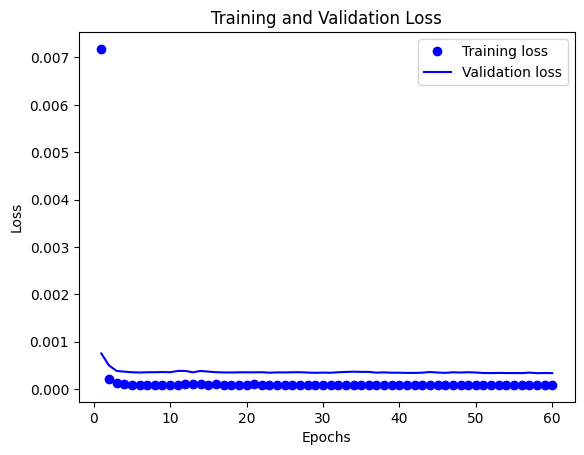

In [82]:

# Build the model using LSTM layers
model_LSTM = tf.keras.Sequential()
for i in range(n_layers - 1):
    model_LSTM.add(tf.keras.layers.LSTM(n_neurons, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model_LSTM.add(tf.keras.layers.LSTM(n_neurons, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'))
model_LSTM.add(tf.keras.layers.Dense(n_outputs))

# Compile the model
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Train the model with adjusted data
history_LSTM = model_LSTM.fit(x_train_adjusted, y_train_residual, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid_adjusted, y_valid_residual))

# Make predictions using adjusted test set
y_train_pred_residual_LSTM = model_LSTM.predict(x_train_adjusted)
y_valid_pred_residual_LSTM = model_LSTM.predict(x_valid_adjusted)
y_test_pred_residual_LSTM = model_LSTM.predict(x_test_adjusted)

# Final predictions (basic model prediction + predicted residual)
y_train_final_pred_LSTM = y_train_ma + y_train_pred_residual_LSTM[:y_train_ma.shape[0], :]
y_valid_final_pred_LSTM = y_valid_ma + y_valid_pred_residual_LSTM[:y_valid_ma.shape[0], :]
y_test_final_pred_LSTM = y_test_ma + y_test_pred_residual_LSTM[:y_test_ma.shape[0], :]

# Extract the history of loss and validation loss
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/60
11/11 [==============================] - 14s 903ms/step - loss: 0.0017 - val_loss: 4.1107e-04
Epoch 2/60
11/11 [==============================] - 6s 523ms/step - loss: 1.5273e-04 - val_loss: 5.8302e-04
Epoch 3/60
11/11 [==============================] - 8s 755ms/step - loss: 1.0978e-04 - val_loss: 3.6100e-04
Epoch 4/60
11/11 [==============================] - 6s 548ms/step - loss: 9.6242e-05 - val_loss: 3.5873e-04
Epoch 5/60
11/11 [==============================] - 6s 562ms/step - loss: 9.6633e-05 - val_loss: 4.0284e-04
Epoch 6/60
11/11 [==============================] - 8s 738ms/step - loss: 9.8154e-05 - val_loss: 3.6501e-04
Epoch 7/60
11/11 [==============================] - 6s 519ms/step - loss: 9.5021e-05 - val_loss: 3.5232e-04
Epoch 8/60
11/11 [==============================] - 8s 788ms/step - loss: 9.3552e-05 - val_loss: 3.5057e-04
Epoch 9/60
11/11 [==============================] - 6s 522ms/step - loss: 9.3440e-05 - val_loss: 3.6874e-04
Epoch 10/60
11/11 [============

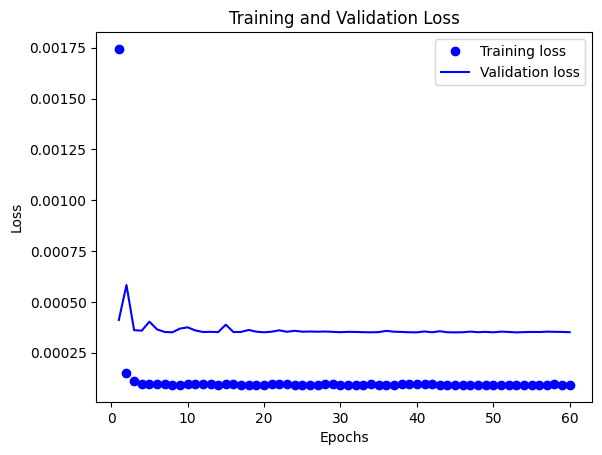

In [83]:
model_LSTM1 = tf.keras.Sequential([
    # Add LSTM layers, note that input shape is required for the first layer.
    tf.keras.layers.LSTM(n_neurons, return_sequences=True, input_shape=(19, n_inputs)),
    tf.keras.layers.LSTM(n_neurons, return_sequences=True),
    # You can only have return_sequences=False in the last LSTM layer
    tf.keras.layers.LSTM(n_neurons, return_sequences=False),
    # Output layer
    tf.keras.layers.Dense(n_outputs)
])

# Compile the model
model_LSTM1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the residuals with adjusted datasets
history_LSTM1 = model_LSTM1.fit(x_train_adjusted, y_train_residual, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid_adjusted, y_valid_residual))

# Make predictions (these are now residual predictions)
y_train_pred_residual_LSTM1 = model_LSTM1.predict(x_train)
y_valid_pred_residual_LSTM1 = model_LSTM1.predict(x_valid)
y_test_pred_residual_LSTM1 = model_LSTM1.predict(x_test)
# Adjust the length of predicted residuals to match the moving averages
y_train_pred_residual_adjusted = y_train_pred_residual_LSTM1[-y_train_ma.shape[0]:]
y_valid_pred_residual_adjusted = y_valid_pred_residual_LSTM1[-y_valid_ma.shape[0]:]
y_test_pred_residual_adjusted = y_test_pred_residual_LSTM1[-y_test_ma.shape[0]:]

# Calculate final predictions (basic model prediction + predicted residual)
y_train_final_pred_LSTM1 = y_train_ma + y_train_pred_residual_adjusted
y_valid_final_pred_LSTM1 = y_valid_ma + y_valid_pred_residual_adjusted
y_test_final_pred_LSTM1 = y_test_ma + y_test_pred_residual_adjusted


# Extract the history of loss and validation loss
loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# use GRU cell

Epoch 1/60
11/11 [==============================] - 8s 413ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 2/60
11/11 [==============================] - 5s 411ms/step - loss: 5.2429e-04 - val_loss: 9.0083e-04
Epoch 3/60
11/11 [==============================] - 3s 251ms/step - loss: 1.7517e-04 - val_loss: 5.7661e-04
Epoch 4/60
11/11 [==============================] - 3s 250ms/step - loss: 1.1774e-04 - val_loss: 4.2624e-04
Epoch 5/60
11/11 [==============================] - 3s 249ms/step - loss: 1.0399e-04 - val_loss: 3.9707e-04
Epoch 6/60
11/11 [==============================] - 4s 338ms/step - loss: 1.0048e-04 - val_loss: 3.7169e-04
Epoch 7/60
11/11 [==============================] - 5s 417ms/step - loss: 9.3857e-05 - val_loss: 3.5390e-04
Epoch 8/60
11/11 [==============================] - 3s 253ms/step - loss: 9.2909e-05 - val_loss: 3.6839e-04
Epoch 9/60
11/11 [==============================] - 3s 246ms/step - loss: 9.4507e-05 - val_loss: 3.5050e-04
Epoch 10/60
11/11 [=================

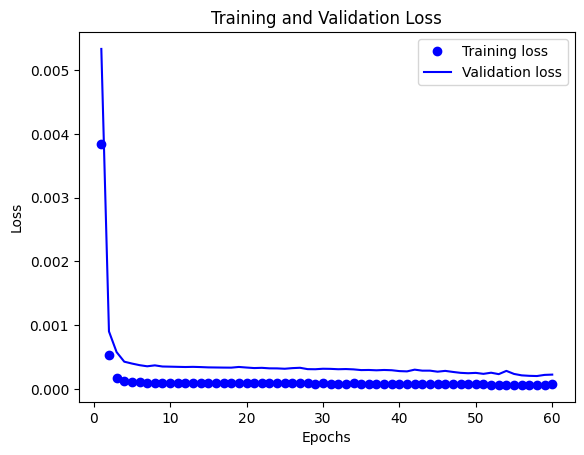

In [84]:
model_GRU = tf.keras.Sequential()
for _ in range(n_layers - 1):
    model_GRU.add(tf.keras.layers.GRU(n_neurons, return_sequences=True, activation='tanh'))
model_GRU.add(tf.keras.layers.GRU(n_neurons, activation='tanh'))  # Last layer does not return sequences
model_GRU.add(tf.keras.layers.Dense(n_outputs))

model_GRU.compile(optimizer='adam', loss='mean_squared_error')
# Trim x_train and x_valid to match the length of y_train_residual and y_valid_residual
x_train_adjusted = x_train[-y_train_residual.shape[0]:]
x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:]

# Verify that the shapes now match
assert x_train_adjusted.shape[0] == y_train_residual.shape[0]
assert x_valid_adjusted.shape[0] == y_valid_residual.shape[0]

# Train the model on residuals

history_GRU = model_GRU.fit(x_train_adjusted, y_train_residual, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid_adjusted, y_valid_residual))

# Make predictions
# Predict residuals

y_train_pred_residual_GPU = model_GRU.predict(x_train_adjusted)
y_valid_pred_residual_GPU = model_GRU.predict(x_valid_adjusted)
y_test_pred_residual_GPU = model_GRU.predict(x_test)  # Assuming x_test is correctly adjusted
# Trim the predicted residuals to match the length of the moving averages
y_test_pred_residual_adjusted_GPU = y_test_pred_residual_GPU[-y_test_ma.shape[0]:]

# Calculate final predictions (basic model prediction + predicted residual)
y_train_final_pred_GPU = y_train_ma + y_train_pred_residual_GPU
y_valid_final_pred_GPU = y_valid_ma + y_valid_pred_residual_GPU
y_test_final_pred_GPU = y_test_ma + y_test_pred_residual_adjusted_GPU



# run graph
# Extract the history of loss and validation loss
loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Predictions <a class="anchor" id="5-bullet"></a>

In [85]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.25/0.37/0.39


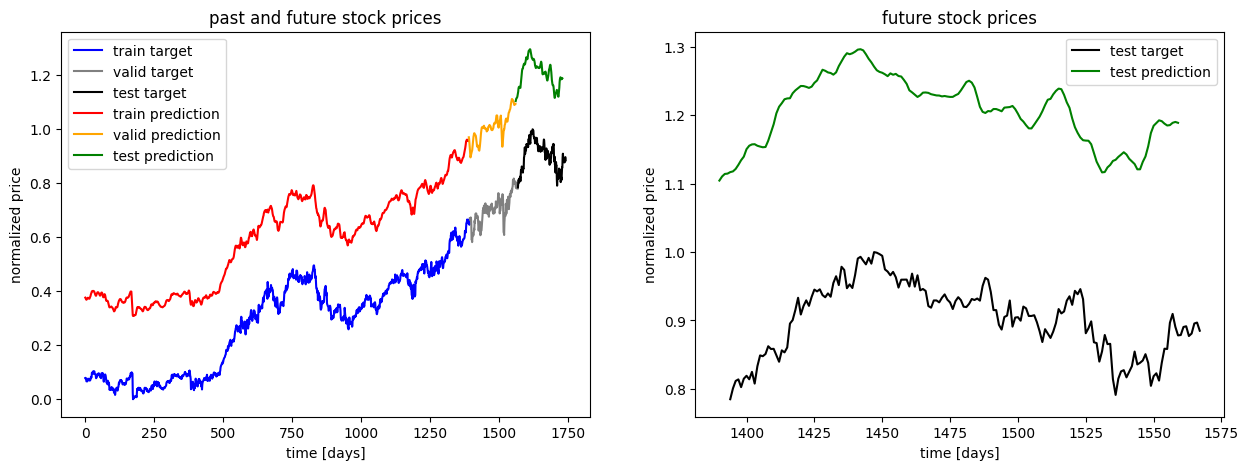

In [86]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_final_pred.shape[0]),y_train_final_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_final_pred.shape[0], y_train_final_pred.shape[0]+y_valid_final_pred.shape[0]),
         y_valid_final_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_final_pred.shape[0]+y_valid_final_pred.shape[0],
                   y_train_final_pred.shape[0]+y_valid_final_pred.shape[0]+y_test_final_pred.shape[0]),
         y_test_final_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_final_pred.shape[0], y_train_final_pred.shape[0]+y_test_final_pred.shape[0]),
         y_test_final_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');
y_train_adjusted = y_train[-y_train_final_pred.shape[0]:]

corr_price_development_train = np.sum(np.equal(np.sign(y_train_adjusted[:,1]-y_train_adjusted[:,0]),
                                                np.sign(y_train_final_pred[:,1]-y_train_final_pred[:,0])).astype(int)) / y_train_adjusted.shape[0]
y_valid_adjusted = y_valid[-y_valid_final_pred.shape[0]:]
y_test_adjusted = y_test[-y_test_final_pred.shape[0]:]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_adjusted[:,1]-y_valid_adjusted[:,0]),
                                               np.sign(y_valid_final_pred[:,1]-y_valid_final_pred[:,0])).astype(int)) / y_valid_adjusted.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test_adjusted[:,1]-y_test_adjusted[:,0]),
                                              np.sign(y_test_final_pred[:,1]-y_test_final_pred[:,0])).astype(int)) / y_test_adjusted.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
